# Model Type 1: Global parameters - MSE loss

In [1]:
import pycuda.driver as cuda
cuda.init()

# Count the number of GPUs available
num_devices = cuda.Device.count()

print("Number of CUDA devices:", num_devices)

# Loop through devices
for i in range(num_devices):
    device = cuda.Device(i)
    print(f"Device #{i}: {device.name()}")
    compute_capability = device.compute_capability()
    print(f"  Compute Capability: {compute_capability[0]}.{compute_capability[1]}")
    print(f"  Total Memory: {device.total_memory() // (1024**2)} MB")


Number of CUDA devices: 1
Device #0: NVIDIA GeForce RTX 3080
  Compute Capability: 8.6
  Total Memory: 10239 MB


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim import SGD
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import mse_loss
from torch.nn.functional import mse_loss
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import time

# Local application/library specific imports
import importlib
import sys
import os
base_path = 'C:/Users/Henri/Emilie/Thesis'
sys.path.append(base_path + '/code')
import project_functions as pf
importlib.reload(pf) # Reloading the local module 

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")
    
base_path = 'C:/Users/Henri/Emilie/Thesis'

# Paths for saving figures
modeltype = 'M1'
loss = 'MSE'
param_string = f"{modeltype}_weighted_{loss}"

fig_string = base_path + '/figures/' + param_string
print(fig_string)

CUDA is available. Using GPU.
C:/Users/Henri/Emilie/Thesis/figures/M1_weighted_MSE


### Load data

In [3]:
class ZR_dataset(Dataset):
    def __init__(self, csv_file):
        """
        Args:
            csv_file (string): Path to the csv file
        """
        # Load the dataset
        df = pd.read_csv(csv_file)
        
        # Filter out rows where R or Z are NaN or zero
        df = df[(df['R'] != 0) & (df['Z'] != 0) & ~df['R'].isnull() & ~df['Z'].isnull()]
        
        # Convert 'timestamp' column to datetime
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        
        # Filter the rows where the minute value is a multiple of 10
        self.data_frame = df[df['timestamp'].dt.minute % 10 == 0]

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        # Extract the target value
        R = self.data_frame.iloc[idx]['R']
        Z = self.data_frame.iloc[idx]['Z']
        #StationId = self.data_frame.iloc[idx]['stationId']
        #t = self.data_frame.iloc[idx]['timestamp']
        
        R = torch.tensor(R, dtype=torch.float) 
        Z = torch.tensor(Z, dtype=torch.float) 
        
        return {'R': R, 'Z': Z}#, 't': t, 'stationId': StationId}


### Estimate A and B global

In [4]:
start_time = time.time()

NUM_EPOCHS = 100 
LEARNING_RATE = 0.001 # 0.001 convergence, but maybe to high
BATCH_SIZE = 1024

# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Load data
train_dataset = ZR_dataset(csv_file=base_path + f'/data/trainZR_v3_31.csv')
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

validation_dataset = ZR_dataset(csv_file=base_path + f'/data/valZR_v3_31.csv')
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

# For plotting
losses = []
validation_losses = []
As = []
Bs = []
epsilon = 1e-6 

# Initialize A and B as tensors with requires_grad=True and move them to the selected device
A = torch.tensor([1.0], requires_grad=True, device=device) # Starting guess
B = torch.tensor([1.6], requires_grad=True, device=device)  # Starting guess

# Optimizer - optimize A and B directly
optimizer = optim.Adam([A, B], lr=LEARNING_RATE)
huber_loss = nn.SmoothL1Loss()

# Example training loop
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for batch in train_dataloader:    
        optimizer.zero_grad()
    
        Z = batch['Z'].unsqueeze(1).to(device)
        logR_pred = torch.log((Z/200)/A)/B
        logR_true = torch.log(batch['R'].unsqueeze(1).to(device) * 60)
        
        
        # Calculate weighted loss
        loss = torch.mean((logR_pred - logR_true) ** 2)
        
        # Backpropagation
        loss.backward()
        
        # Update A and B
        optimizer.step()
        running_loss += loss.item() 

    # Calculate average loss over the epoch
    epoch_loss = running_loss / len(train_dataloader.dataset)
    losses.append(epoch_loss)
    
    # Validation loop
    with torch.no_grad():  # No need to track gradients during validation
        validation_loss = 0.0
        for batch in validation_dataloader:
            Z = batch['Z'].unsqueeze(1).to(device)
            logR_pred = torch.log((Z/200)/A)/B
            logR_true = torch.log(batch['R'].unsqueeze(1).to(device) * 60)

            
            # Calculate validation loss
            v_loss = torch.mean((logR_pred - logR_true) ** 2)
            validation_loss += v_loss.item()

        # Calculate average validation loss over the epoch
        validation_loss /= len(validation_dataloader.dataset)
        validation_losses.append(validation_loss)
        
    #scheduler.step()
    As.append(A.item() * 200)
    Bs.append(B.item())
    

    if epoch % 1 == 0:
        print(f"Epoch {epoch + 1}, Loss: {epoch_loss}, Validation Loss: {validation_loss}, A: {A.item() * 200}, B: {B.item()}")

end_time = time.time()
elapsed_time = end_time - start_time

Using cuda device
Epoch 1, Loss: 0.0010131012529228023, Validation Loss: 0.0009611463825434178, A: 152.65482664108276, B: 1.8787833452224731
Epoch 2, Loss: 0.0008024222647849428, Validation Loss: 0.0008230503266646914, A: 144.66568231582642, B: 2.091905117034912
Epoch 3, Loss: 0.0007063838275459961, Validation Loss: 0.0007436705032616167, A: 149.31572675704956, B: 2.272350549697876
Epoch 4, Loss: 0.0006487663435251849, Validation Loss: 0.0006954146391579019, A: 154.5538067817688, B: 2.430561065673828
Epoch 5, Loss: 0.0006110529709092723, Validation Loss: 0.0006620930519194094, A: 159.23616886138916, B: 2.5730762481689453
Epoch 6, Loss: 0.0005848933085052908, Validation Loss: 0.0006379960991014783, A: 164.572274684906, B: 2.703671455383301
Epoch 7, Loss: 0.0005661093501424186, Validation Loss: 0.0006212795451775691, A: 169.3440079689026, B: 2.824704885482788
Epoch 8, Loss: 0.0005522793428297944, Validation Loss: 0.0006089124856752536, A: 173.5639214515686, B: 2.937774419784546
Epoch 9, 

Epoch 68, Loss: 0.0005109119527456762, Validation Loss: 0.0005762066414479464, A: 217.53301620483398, B: 3.9699771404266357
Epoch 69, Loss: 0.000510906692889427, Validation Loss: 0.0005763636045628985, A: 217.27793216705322, B: 3.9615871906280518
Epoch 70, Loss: 0.0005108767901473502, Validation Loss: 0.0005760115806106559, A: 219.46184635162354, B: 3.957056760787964
Epoch 71, Loss: 0.0005108928517383527, Validation Loss: 0.000576300803280273, A: 217.27380752563477, B: 3.9641849994659424
Epoch 72, Loss: 0.0005108636085189092, Validation Loss: 0.0005764196294721996, A: 219.3187952041626, B: 3.9607315063476562
Epoch 73, Loss: 0.0005108728022150022, Validation Loss: 0.0005752254090484905, A: 218.82140636444092, B: 3.956728458404541
Epoch 74, Loss: 0.0005108859442226697, Validation Loss: 0.0005763402302622749, A: 219.33438777923584, B: 3.952641010284424
Epoch 75, Loss: 0.0005108640386116728, Validation Loss: 0.0005759875345528028, A: 219.75476741790771, B: 3.95690655708313
Epoch 76, Loss: 

In [5]:
print(f"Training took {elapsed_time/60/60:.2f} hours.")

Training took 1.27 hours.


In [6]:
A_est = np.array(As)[80:].mean()
B_est = np.array(Bs)[80:].mean()
print('Estimated A:\t:', A_est)
print('Estimated B:\t:', B_est)

Estimated A:	: 218.606858253479
Estimated B:	: 3.9631158113479614


In [7]:
A_var = np.array(As)[80:].var()
B_var = np.array(Bs)[80:].var()
print('Variance of A:\t:', A_var)
print('Variance of B:\t:', B_var)

Variance of A:	: 0.6271227422075754
Variance of B:	: 1.2671357913518477e-05


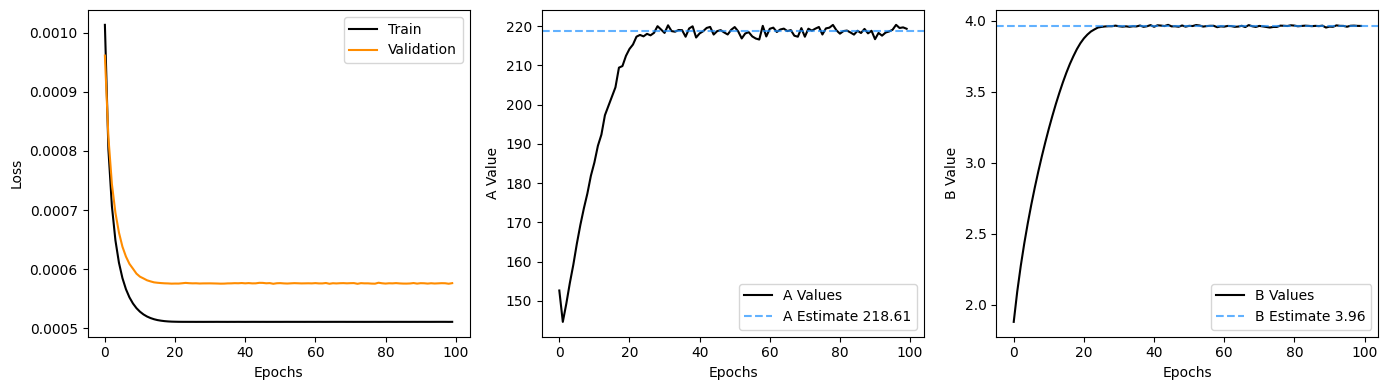

In [8]:
epochs = np.arange(NUM_EPOCHS)
fig, axs = plt.subplots(1, 3, figsize=(14, 4))  # Adjust the size as needed

# Plot training and validation losses
axs[0].plot(epochs, losses, color = 'black', label = 'Train')
axs[0].plot(epochs, validation_losses, color = 'darkorange', label = 'Validation')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot A values
axs[1].plot(epochs, As, label='A Values', color = 'black')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('A Value')
axs[1].axhline(y=A_est, color='dodgerblue', linestyle='--', alpha = 0.7, label = f'A Estimate {A_est:.2f}')
axs[1].legend()

# Plot B values
axs[2].plot(epochs, Bs, label='B Values', color = 'black')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('B Value')
axs[2].axhline(y=B_est, color='dodgerblue', linestyle='--', alpha = 0.7, label = f'B Estimate {B_est:.2f}')
axs[2].legend()

plt.tight_layout()
save_path = fig_string + 'model_conv.png'
plt.savefig(save_path, bbox_inches='tight', pad_inches=0.01, dpi=300)
plt.show()

#### Evaluatuion

In [9]:
df_test = pd.read_csv(base_path + f'/data/testZR_v3.csv')
valid_idx = (df_test['R'] != 0) & (df_test['Z'] != 0) & ~df_test['R'].isnull() & ~df_test['Z'].isnull()

# Convert timestamp to datetime
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
df_test = df_test[df_test['timestamp'].dt.minute % 10 == 0]
df_test = df_test.dropna(subset=['Z', 'R'])

df_test['dBZ'] = np.where(df_test['Z'] > 0, 10 * np.log10(df_test['Z']), 0)
df_test['R_pred'] = np.array(pf.dbz_to_R_marshall_palmer(df_test['dBZ'], A_est, B_est))
df_test['R_true'] = np.array(df_test['R']*60)
df_test['MP'] = np.array(pf.dbz_to_R_marshall_palmer(df_test['dBZ'], 200, 1.6))

df_test['error_standard'] = df_test['R_true'] - df_test['MP']
df_test['error_opt'] = df_test['R_true'] - df_test['R_pred']


# Extract month and year for grouping
df_test['year'] = df_test['timestamp'].dt.year
df_test['month'] = df_test['timestamp'].dt.month

C:\Users\Henri\anaconda3\envs\pytorch_trial_0\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print('MP: \t', np.sqrt(mean_squared_error(df_test['R_true'] , df_test['MP'] )))
print('Model: \t', np.sqrt(mean_squared_error(df_test['R_true'] , df_test['R_pred'] )))

MP: 	 0.9183279189979675
Model: 	 0.7149924670975902


In [ ]:
# Example 1
pf.plot_hyetograph(df_test, station_id=5049, 
               start_timestamp='2023-04-12 20:00:00', 
               end_timestamp='2023-04-13 08:30:00', 
               A_est=A_est, B_est=B_est, save_path = fig_string,
               tick_interval=6)  

# Example 2
pf.plot_hyetograph(df_test, station_id=5195,
               start_timestamp='2023-07-26 00:00:00', 
               end_timestamp='2023-07-26 16:00:00', 
               A_est=A_est, B_est=B_est, save_path = fig_string,
               tick_interval=6)  

# Example 3
pf.plot_hyetograph(df_test, station_id=5049,
               start_timestamp='2023-08-24 15:00:00', 
               end_timestamp='2023-08-25 08:00:00', 
               A_est=A_est, B_est=B_est, save_path = fig_string,
               tick_interval=6)  

# Example 4 
pf.plot_hyetograph(df_test, station_id=5340,
               start_timestamp='2023-10-02 20:00:00', 
               end_timestamp='2023-10-03 11:00:00', 
               A_est=A_est, B_est=B_est, save_path = fig_string,
               tick_interval=6)  

# Example 5 
pf.plot_hyetograph(df_test, station_id=5340,
               start_timestamp='2023-12-21 00:00:00', 
               end_timestamp='2023-12-21 11:00:00', 
               A_est=A_est, B_est=B_est, save_path = fig_string,
               tick_interval=6)  

# Example 6 
pf.plot_hyetograph(df_test, station_id=5732,
               start_timestamp='2023-04-11 00:00:00', 
               end_timestamp='2023-04-11 18:00:00', 
               A_est=A_est, B_est=B_est, save_path = fig_string,
               tick_interval=6)  

# Example 7 
pf.plot_hyetograph(df_test, station_id=5461,
               start_timestamp='2023-05-05 20:00:00', 
               end_timestamp='2023-05-06 09:00:00', 
               A_est=A_est, B_est=B_est, save_path = fig_string,
               tick_interval=6)  

### Error Analysis

In [ ]:
# by Rain Intensity Group
pf.plot_goruped_rain_intensity_error(df_test.loc[valid_idx,:].copy(), save_path = fig_string)

In [ ]:
# by month
pf.plot_rmse_by_month(df_test.loc[valid_idx,:].copy(), save_path = fig_string)

In [ ]:
# Error metrics for differnt aggregation levels
metrics_df = pf.calculate_metrics(df_test.loc[valid_idx,:].copy())
metrics_df_MP = pf.calculate_metrics_MP(df_test.loc[valid_idx,:].copy())

pf.plot_error_metrics(metrics_df, metrics_df_MP, save_path = fig_string)

In [ ]:
metrics_MP = pf.evaluation_metrics(df_test['R_true'].loc[valid_idx], df_test['MP'].loc[valid_idx])
metrics_MP_opt = pf.evaluation_metrics(df_test['R_true'].loc[valid_idx], df_test['R_pred'].loc[valid_idx])

# Create a DataFrame from the metrics
metrics_df = pd.DataFrame({
    'MP': metrics_MP,
    'MP_opt': metrics_MP_opt,
})

# Transpose the DataFrame to have models as rows and metrics as columns
metrics_df = metrics_df.T
metrics_df

In [ ]:
print('Total absolute error optimized parameters:', abs(df_test['R_true'].loc[valid_idx] / 6  -  df_test['R_pred'].loc[valid_idx] / 6).sum())
print('Total absolute error standard parameters:', abs(df_test['R_true'].loc[valid_idx] / 6  -  df_test['MP'].loc[valid_idx] / 6).sum())